In [0]:
!apt-get install graphviz
!pip install graphviz

!mkdir dot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
mkdir: cannot create directory ‘dot’: File exists


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import unittest
import math
from sklearn import metrics
from sklearn.tree import export_graphviz
import IPython, graphviz, re

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    Source from: https://github.com/fastai/fastai/blob/e6b56de53f80d2b2d39037c82d3a23ce72507cd7/old/fastai/structured.py#L22
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

# Load the data

Data [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [0]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv

--2019-04-03 09:32:27--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv.2’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.04s   

2019-04-03 09:32:28 (12.3 MB/s) - ‘house_prices_train.csv.2’ saved [460676/460676]

--2019-04-03 09:32:31--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP reques

In [0]:
df_train = pd.read_csv('house_prices_train.csv')
df_test = pd.read_csv('house_prices_test.csv')

# Decision trees

![](https://www.xoriant.com/blog/wp-content/uploads/2017/08/Decision-Trees-modified-1.png)

Decision tree models can be used for both classification and regression. The algorithms for building trees breaks down a data set into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node has two or more branches. Leaf node represents a classification or decision (used for regression). The topmost decision node in a tree which corresponds to the best predictor (most important feature) is called a root node. Decision trees can handle both categorical and numerical data.

In [0]:
X = df_train[['OverallQual', 'GrLivArea', 'GarageCars']]
y = df_train['SalePrice']

# Cost function

Root Mean Squared Error:

$$RMSE =  \sqrt{\frac{1}{m} \sum_{i=1}^{m} (y^{(i)} - h(x^{(i)}))^2}$$

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(h, y):
  return sqrt(mean_squared_error(h, y))

# Using scikit-learn

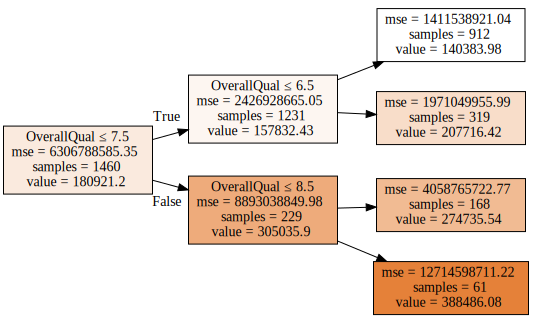

In [0]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False, random_state=RANDOM_SEED)
reg.fit(X, y)

draw_tree(reg.estimators_[0], X, precision=2)

In [0]:
preds = reg.predict(X)
metrics.r2_score(y, preds)

0.6336246655552089

In [0]:
rmse(preds, y)

48069.23940764968

# Building our own Decision Tree

We're going to split our tree based on information gain. Concretely, we will try to split every feature in a way that both groups have as low standard deviation as possible. In that way we're going to minimize the RMSE.

In [0]:
class Node:

    def __init__(self, x, y, idxs, min_leaf=5):
        self.x = x 
        self.y = y
        self.idxs = idxs 
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for c in range(self.col_count): self.find_better_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf)
        
    def find_better_split(self, var_idx):
      
        x = self.x.values[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue

            curr_score = self.find_score(lhs, rhs)
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
                
    def find_score(self, lhs, rhs):
        y = self.y[self.idxs]
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        return lhs_std * lhs.sum() + rhs_std * rhs.sum()
                
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
                
    @property
    def is_leaf(self): return self.score == float('inf')                

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

In [0]:
class DecisionTreeRegressor:
  
  def fit(self, X, y, min_leaf = 5):
    self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf)
    return self
  
  def predict(self, X):
    return self.dtree.predict(X.values)
    

# Evaluation

In [0]:
regressor = DecisionTreeRegressor().fit(X, y)
preds = regressor.predict(X)

In [0]:
metrics.r2_score(y, preds)

0.8504381072711565

In [0]:
rmse(preds, y)

30712.460628635836

# Sending to Kaggle

In [0]:
X_test = df_test[['OverallQual', 'GrLivArea', 'GarageCars']]
pred_test = regressor.predict(X_test)

submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': pred_test})
submission.to_csv('submission.csv', index=False)

In [0]:
from google.colab import files
files.download('submission.csv')

# Resources

[Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)